##  Ejercicio 2


En los códigos que se presentan a continuación, importamos las librerías necesarias para el desarrollo del ejercicio y subimos los datos de la red de delfines que vamos a analizar.

In [15]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pylab as plt
from urllib.request import urlopen
from random import shuffle
from copy import deepcopy

%matplotlib inline

In [16]:
red_delf = nx.read_gml(urlopen("https://raw.githubusercontent.com/MarianoNicolini17/TP1/master/Datos/dolphins.gml"))
gen_delf = urlopen("https://raw.githubusercontent.com/MarianoNicolini17/TP1/master/Datos/dolphinsGender.txt").readlines()

for i in range(len(gen_delf)):
    gen_delf[i]=gen_delf[i].decode()
    
sex_delf = []   
for i in range(len(gen_delf)):
    a = gen_delf[i].rstrip('\n').split('\t')
    sex_delf.append(a)

Definimos las funciones que vamos a utilizar para asignar el género de cada delfín. Además, definimos la función hEdges que me permite saber cuántos enlaces homofílicos y cuántos enlaces heterofílicos hay en mi red.

In [17]:
def atributoNodos(r, alist, atributo):
# Toma como argumentos una red, una lista de listas, donde cada una de ellas
# indica el atributo que se le va a asignar a cada nodo de la red. Devuelve la
# red con ese atributo ya asociado.
    for idx, nodo in enumerate(np.array(alist).transpose()[0]):
        r.nodes[nodo][atributo] = np.array(alist).transpose()[1][idx]
    
# ----------------------------------------------------------------------------- 
        
def contadorGenero(r): #Generalizarlo para cualquier atributo
    a = list(nx.get_node_attributes(r, 'gender').values())
    return a.count('m'), a.count('f'), a.count('NA')

# -----------------------------------------------------------------------------
    
def generoAzar(r):
# Toma una red donde sus nodos tienen el atributo "genero" y los distribuye al
# azar. 
    ng = contadorGenero(r)
    n = list(r.nodes)
    shuffle(n)
    ra = deepcopy(r)
    for i in range(ng[0]):
        ra.nodes[n[i]]['gender'] = 'm'
    for i in range(ng[0], ng[0]+ng[1]):
         ra.nodes[n[i]]['gender'] = 'f'
    for i in range(ng[0]+ng[1], ng[0]+ng[1]+ng[2]):
         ra.nodes[n[i]]['gender'] = "NA"
    return ra

In [18]:
def hEdges(r, atributo):
# Recibe como argumentos una red y un cierto atributo (str) para el cual se 
# quiere ver cuántos enlaces hay entre nodos con el mismo atributo y
# cuántos entre nodos con atributos diferentes.
# Devuelve una tupla de dos números, en el primer lugar la cantidad de enlaces
# entre nodos del mismo atributo y en el segundo entre nodos de atributos 
# diferentes.
    homo = 0
    hetero = 0
    n = len(r.edges)
    for edge in r.edges:
        if r.nodes[edge[0]][atributo] == r.nodes[edge[1]][atributo]:
            homo += 1
        else:
            hetero += 1
    return homo/n, hetero/n
            
# -----------------------------------------------------------------------------            
            
def nulaAtributo(r, pasos):
# Recibe como argumento una red y una cantidad de pasos sobre los cuales se va
# a iterar.
# Devuelve dos arrays, una con el número de enlaces homofílicos y otra con el 
# número de enlaces heterofílicos, para cada red creada al azar.
    a = []
    for i in range(pasos):
        ra = generoAzar(r)
        a.append(hEdges(ra, 'gender'))
    lhomo = np.array(a).transpose()[0]
    lhetero = np.array(a).transpose()[1]
    return lhomo, lhetero 

Aplicamos la función atributoNodos para asociar las dos secuencias de datos que tenemos, una sobre los delfines y las interacciones entre ellos, y otra con la información del género de cada uno. Luego, graficamos la red, utilizando un spring layout dando información del género de los delfines en el grafo. Las hembras están representadas mediante nodos rojos, los machos mediante nodos azules y los NA mediante nodos amarillos.

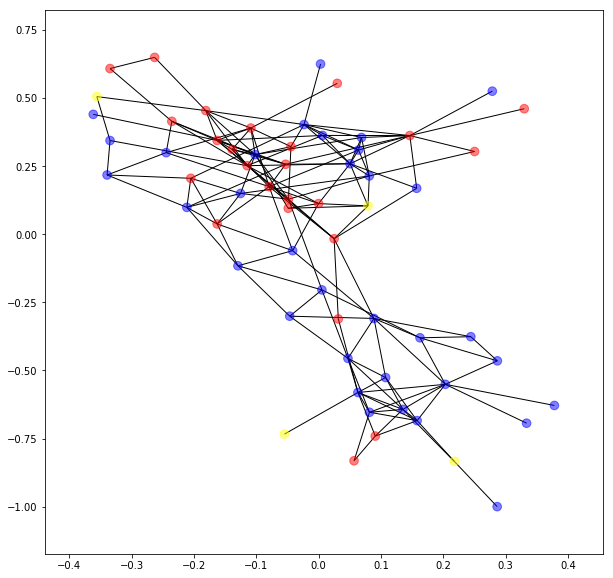

In [47]:
atributoNodos(red_delf, sex_delf, 'gender')    
    
graph_pos=nx.spring_layout(red_delf, dim=2)

plt.figure(figsize=(10,10))

nx.draw_networkx_nodes(red_delf, graph_pos, node_size=75,
                       node_color = ["blue" if g=="m" else "red" if g=="f" else \
                                     "yellow" for g in nx.get_node_attributes(red_delf, 'gender').values()],
                       alpha=0.5)
nx.draw_networkx_edges(red_delf, graph_pos)
#nx.draw_networkx_labels(red_delf,graph_pos, font_size=8, font_family='sans-serif')

#plt.savefig("plot.png", dpi=1000)
plt.show()

Esta elección de layout parecería dejar en evidencia un comportamiento homofílico en en el atributo "género", más marcado entre los delfines machos que entre las hembras. También se pueden observar regiones con más densidad de interconexiones entre nodos y otras menos densas, como es de esperar, naturalmente, en una red social.

Mediante una iteración de 10000 pasos, se construyó la distribución de probabilidades correspondiente a que no existe una relación entre la topología de la red y la asignación del atributo "género", i.e., la hipótesis nula. En cada iteración, el género de cada delfín de la red fue asignado aleatoriamente, manteniendo la cantidad de delfines de cada género fijado con los mismos valores de la red real, para después calcular la fracción de enlaces homofílicos y heterofílicos.

In [42]:
size = 10000
x1 = nulaAtributo(red_delf, size)[0]
x2 = nulaAtributo(red_delf, size)[1]

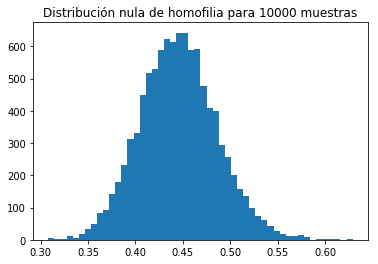

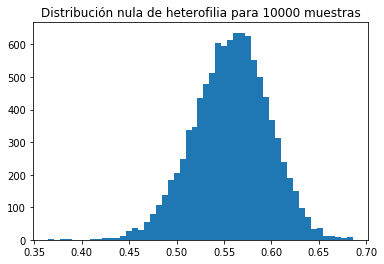

In [44]:
plt.hist(x1, bins='scott')
plt.title("Distribución nula de homofilia para {} muestras".format(size))
plt.show()

plt.hist(x2, bins='scott')
plt.title("Distribución nula de heterofilia para {} muestras".format(size))
plt.show()

histhomo, bin_edges1 = np.histogram(x1, bins='scott', density=True)
histhete, bin_edges2 = np.histogram(x2, bins='scott', density=True)

Para estimar $h =$ $\textit{"fraccion de enlaces homofilicos"}$ vamos a utilizar $\hat{h} = \bar{h}_i$, el valor medio del histograma y suponiendo que no hay relación entre la topologia de la red y la asignacion de sexos, estimaremos el error con $\sigma$, el desvío de la muestra. Con este propósito se escribió el siguiente código:

In [24]:
def mediaHist(alturabins, bin_edges):
    suma = 0
    n = sum(alturabins)
    for i in range(len(alturabins)):
        suma += alturabins[i]*bin_edges[i]
    return suma/n

def desvHist(alturabins, bin_edges):
    suma = 0
    n = sum(alturabins)
    for i in range(len(alturabins)):
        suma += (alturabins[i]*(bin_edges[i] - mediaHist(alturabins, bin_edges))**2)
    return np.sqrt(suma/n)

In [40]:
hm = mediaHist(histhomo, bin_edges1)
hm_err = desvHist(histhomo, bin_edges1)

ht = mediaHist(histhete, bin_edges2)
ht_err = desvHist(histhete, bin_edges2)

print('Valor medio de la fracción de enlaces homofílicos:', hm, 'Incerteza:', hm_err)
print('Valor medio de la fracción de enlaces heterofílicos:', ht, 'Incerteza:', ht_err)

Valor medio de la fracción de enlaces homofílicos: 0.445089308176 Incerteza: 0.0391220910382
Valor medio de la fracción de enlaces heterofílicos: 0.55149627673 Incerteza: 0.0404423110597


A partir de éstos valores, queremos contrastar, con una significancia $s=0.05$, la hipótesis de que nuestra red social de delfines no tiene una relación en su topología con el atributo 'género'. Para esto, escribimos un código que nos permite calcular el p-value observado en la red real.

In [41]:
def CPDHist(hist, bin_edges, x):
# Me calcula la probabilidad acumulada en el histograma hasta un cierto valor x.
# Los argumentos de la función son: un array con las alturas de cada bin del histograma,
# otro array de los límites de cada bin y el valor hasta el que quiero 
# calcular la probabilidad acumulada.
    bin_len = bin_edges[1:] - bin_edges[:-1]
    CP = 0
    i = 0
    while bin_edges[i] < x:
        CP += (hist[i]*bin_len[i])
        i += 1
    return CP

In [45]:
p_val1 = 1 - CPDHist(histhomo, bin_edges1, hEdges(red_delf,'gender')[0])
p_val2 = CPDHist(histhete, bin_edges2, hEdges(red_delf,'gender')[1])
print('El p-value correspondiente a la fracción de enlaces homofílicos de la red es de', p_val1)
print('El p-value correspondiente a la fracción de enlaces heterofílicos de la red es de', p_val2)

El p-value correspondiente a la fracción de enlaces homofílicos de la red es de 0.0005
El p-value correspondiente a la fracción de enlaces heterofílicos de la red es de 0.0003


Así, vemos que el p-value para la distribución de enlaces homofílicos es de $0.0005$. De la misma manera, el p-value para la distribución de enlaces heterofílicos es de $0.0003$. Con el nivel de significancia elegido, claramente podemos descartar la hipótesis nula. Ambos resultados dejan en evidencia que existe una relación entre el género de los delfines y la manera en que éstos se relacionan, es decir, la topología de la red social estudiada. Se puede afirmar que existe homofilia respecto del atributo 'género' en la red.